# Validación de Modelos ML para Predecir Destruction Level en Flood 

## Objetivos

### Validar diferentes modelos para predecir Destruction Level (y) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Flood Type.
    + RandomForestClassifier

## Importar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestClassifier # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Destruction Level en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Destruction Level Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

## Cargar datos

In [2]:
df = pd.read_csv('../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,...,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,...,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,...,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,...,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,...,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,...,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [3]:
df.shape

(16636, 26)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [5]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [6]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Flood

In [7]:
# Filtro principal para Flood
df_flood = df[df['Disaster Type'] == 'Flood']

### Limpieza

#### Borrar columnas

In [8]:
df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_9340\2601801454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Latitude', 'Longitude', 'ISO'], inplace=True)


In [9]:
df_flood.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
12,Flood,NaN,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0
13,Flood,NaN,Belgium,Western Europe,Europe,NaN,NaN,NaN,0,Km2,1906,4,0,1906,4,0,0,0,0


### Valores faltantes

In [10]:
# # Rellenar valores faltantes y nulls con 0, después, borrar filas con valores faltantes
# df_flood = df_flood.copy()
# df_flood.fillna(0, inplace=True)

## Preprocessing

1. Crear columna categórica Flood Type
2. Codificar columna numérica Destruction Level con OneHotEncoder para predecir y

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Nivel de Destrucción

In [11]:
min_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min()
max_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max()
std_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median()

min_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min()
max_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max()
std_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std()
mean_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean()
median_tot_affect = df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median()

min_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median()

In [12]:
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].min())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].max())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].std())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].mean())
print(df_flood['Dis Mag Value'].loc[df_flood['Dis Mag Value'].gt(0)].median())

print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].min())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].max())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].std())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].mean())
print(df_flood['Total Deaths'].loc[df_flood['Total Deaths'].gt(0)].median())

print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].min())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].max())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].std())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].mean())
print(df_flood['Total Affected'].loc[df_flood['Total Affected'].gt(0)].median())

print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].min())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].max())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].std())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].mean())
print(df_flood['Total Damages Adj'].loc[df_flood['Total Damages Adj'].gt(0)].median())

2
2857000
206861.50686270732
92063.0765334834
24681.0
1
3700000
65196.51587469585
1656.5946073793757
16.0
2
238973000
7561334.5755781615
811324.9760785116
11000.0
5
53860097
3156399.414884343
861012.3965244866
87845.0


### Tipos de umbrales de peligrosidad de inundación

In [13]:
type1_threshold = min_dis_mag + std_dis_mag
type2_threshold = min_dis_mag + (2 * std_dis_mag)
type3_threshold = max_dis_mag - std_dis_mag

### Función para crear columna categórica de nivel de impacto: Flood Type

In [14]:
def assign_flood_type(row):
    if row['Dis Mag Value'] < type1_threshold and row['Total Deaths'] < 100 and row['Total Affected'] < 10000 and row['Total Damages Adj'] < 1000000:
        return 'Low' # 1
    elif row['Dis Mag Value'] < type2_threshold and row['Total Deaths'] < 500 and row['Total Affected'] < 100000 and row['Total Damages Adj'] < 10000000:
        return 'Moderate' # 2
    elif row['Dis Mag Value'] < type3_threshold and row['Total Deaths'] < 1000 and row['Total Affected'] < 500000 and row['Total Damages Adj'] < 100000000:
        return 'High' # 3
    else:
        return 'Very High' # 4

In [15]:
df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)
df_flood.head(1)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_9340\3808777197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Flood Type'] = df_flood.apply(assign_flood_type, axis=1)


,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Origin,Associated Dis,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj,Flood Type
12,Flood,NaN,Belgium,Western Europe,Europe,Louvain region,NaN,NaN,0,Km2,1906,5,14,1906,5,14,6,0,0,Low


### Codificación categórica a numérica

#### Convertir Flood Type a Destruction Level numérica con OneHotEncoder

In [16]:
# Crear instancia de OneHotEncoder
encoder = OneHotEncoder()

# Ajustar y transformar la columna 'Flood Type'
flood_type_encoded = encoder.fit_transform(df_flood[['Flood Type']]).toarray()

# Obtener valores únicos en columna 'Flood Type'
unique_flood_types = df_flood['Flood Type'].unique()

# # Crear nuevos nombres de columna para las columnas codificadas
# encoded_feature_names = [f'Flood Type_{flood_type}' for flood_type in unique_flood_types]

# # Crear nuevo DataFrame para las columnas codificadas
# df_encoded = pd.DataFrame(flood_type_encoded, columns=encoded_feature_names)

# # Aplicar one-hot encoding a columna 'Flood Type'
# flood_type_encoded = pd.get_dummies(df_flood['Flood Type'], prefix='Flood Type')

# # Concatenar el DataFrame codificado con el original
# df_flood_encoded = pd.concat([df_flood, flood_type_encoded], axis=1)

# # DataFrame actualizado
# print(df_flood_encoded.head())

# Definir un diccionario de mapeo para las categorías en 'Flood Type' a valores numéricos
destruction_mapping = {'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

# Crear una nueva columna 'Destruction Level' mapeando las categorías 'Flood Type' a valores numéricos
df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)

# Aplicar one-hot encoding a columna 'Flood Type'
destruction_encoded = pd.get_dummies(df_flood['Destruction Level'], prefix='Destruction')

# Concatenar el DataFrame codificado con el original
df_flood_encoded = pd.concat([df_flood, destruction_encoded], axis=1)

# DataFrame actualizado
print(df_flood_encoded.head())


   Disaster Type Disaster Subtype  Country          Region Continent  \
12         Flood              NaN  Belgium  Western Europe    Europe   
13         Flood              NaN  Belgium  Western Europe    Europe   
34         Flood   Riverine flood    China    Eastern Asia      Asia   
39         Flood   Riverine flood    China    Eastern Asia      Asia   
43         Flood   Riverine flood    China    Eastern Asia      Asia   

          Location Origin Associated Dis  Dis Mag Value Dis Mag Scale  ...  \
12  Louvain region    NaN            NaN              0           Km2  ...   
13             NaN    NaN            NaN              0           Km2  ...   
34             NaN    NaN            NaN              0           Km2  ...   
39       Guangzhou    NaN            NaN           3000           Km2  ...   
43         Tianjin    NaN            NaN              0           Km2  ...   

    End Day  Total Deaths  Total Affected  Total Damages Adj  Flood Type  \
12       14           

C:\Users\AleEng\AppData\Local\Temp\ipykernel_9340\2008063618.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = df_flood['Flood Type'].map(destruction_mapping)


#### Revisión df_flood_encoded

In [17]:
df_flood_encoded.shape

(5808, 25)

In [18]:
len(df_flood_encoded)

5808

In [19]:
df_flood_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5808 entries, 12 to 16634
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Disaster Type      5808 non-null   object
 1   Disaster Subtype   3564 non-null   object
 2   Country            5808 non-null   object
 3   Region             5808 non-null   object
 4   Continent          5808 non-null   object
 5   Location           5512 non-null   object
 6   Origin             3446 non-null   object
 7   Associated Dis     1383 non-null   object
 8   Dis Mag Value      5808 non-null   int64 
 9   Dis Mag Scale      5808 non-null   object
 10  Start Year         5808 non-null   int64 
 11  Start Month        5808 non-null   int64 
 12  Start Day          5808 non-null   int64 
 13  End Year           5808 non-null   int64 
 14  End Month          5808 non-null   int64 
 15  End Day            5808 non-null   int64 
 16  Total Deaths       5808 non-null   int64

In [20]:
df_flood.columns

Index(['Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Continent',
       'Location', 'Origin', 'Associated Dis', 'Dis Mag Value',
       'Dis Mag Scale', 'Start Year', 'Start Month', 'Start Day', 'End Year',
       'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj', 'Flood Type', 'Destruction Level'],
      dtype='object')

In [21]:
df_flood['Destruction Level']

12       1
13       1
34       4
39       4
43       4
        ..
16620    1
16628    1
16629    1
16631    3
16634    1
Name: Destruction Level, Length: 5808, dtype: int64

In [22]:
df_flood['Destruction Level'].isnull().sum()

0

#### Imputación de nulos en columna salida (y) Destruction Level con Simple Imputer

In [23]:
# Imputar nulos en la columna de salida (y) que es Destruction Level
df_flood['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])
df_flood['Destruction Level']
# borrar en lugar de imputar
# df = df.dropna('Flood Type')

C:\Users\AleEng\AppData\Local\Temp\ipykernel_9340\2005245492.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flood['Destruction Level'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_flood[['Destruction Level']])


12       1
13       1
34       4
39       4
43       4
        ..
16620    1
16628    1
16629    1
16631    3
16634    1
Name: Destruction Level, Length: 5808, dtype: int64

In [24]:
df_flood['Flood Type'].isna().sum()
df_flood['Flood Type'].unique()
len(df_flood['Flood Type'])

5808

### EDA Visualizaciones de 'Destruction Level' o Nivel de Destrucción

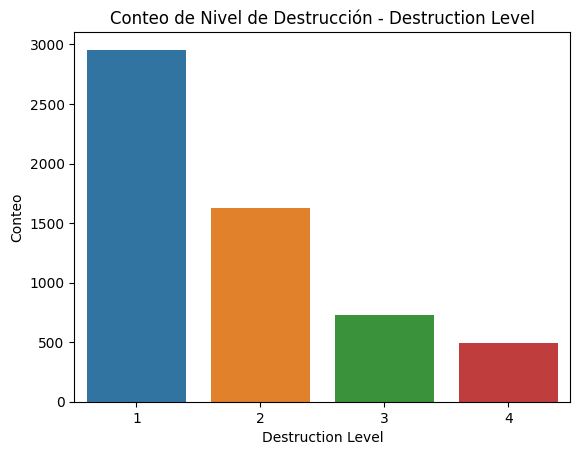

In [25]:
sns.countplot(data=df_flood, x='Destruction Level')
plt.title('Conteo de Nivel de Destrucción - Destruction Level')
plt.xlabel('Destruction Level')
plt.ylabel('Conteo')
plt.show()

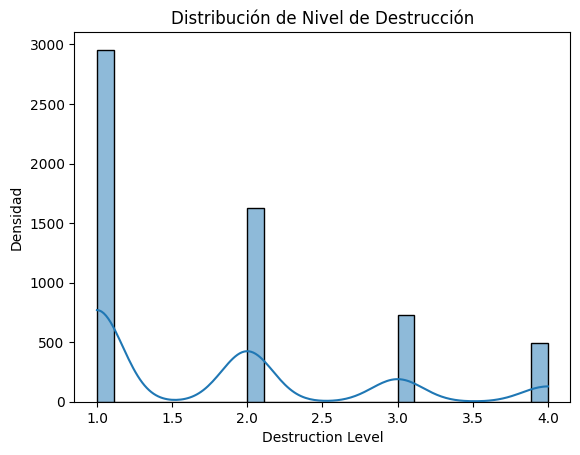

In [26]:
sns.histplot(data=df_flood, x='Destruction Level', kde=True)
plt.title(f'Distribución de Nivel de Destrucción')
plt.xlabel('Destruction Level')
plt.ylabel('Densidad')
plt.show()

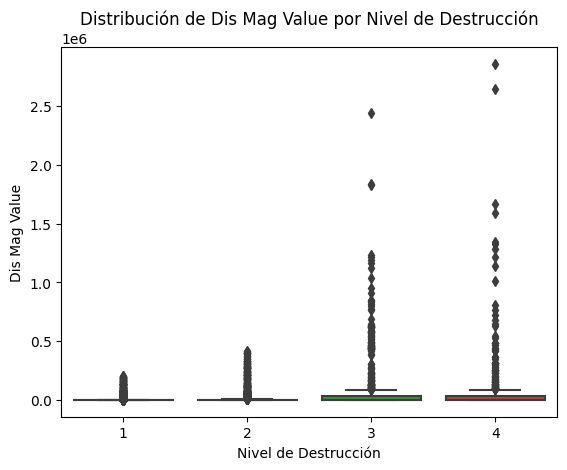

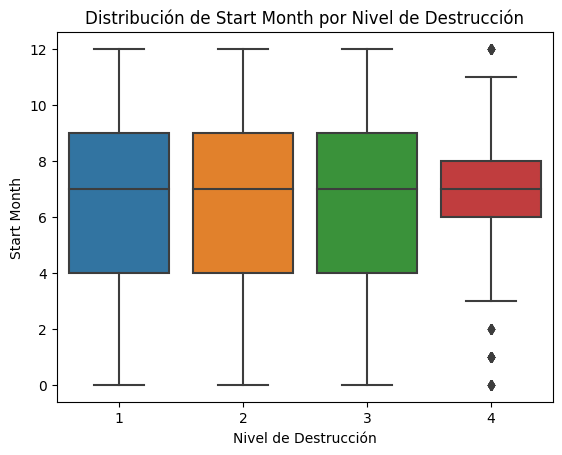

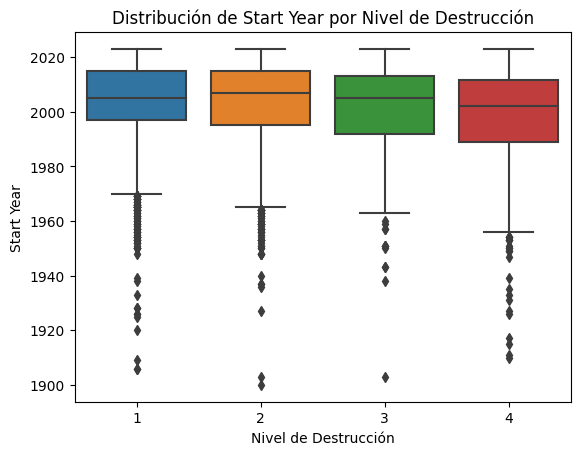

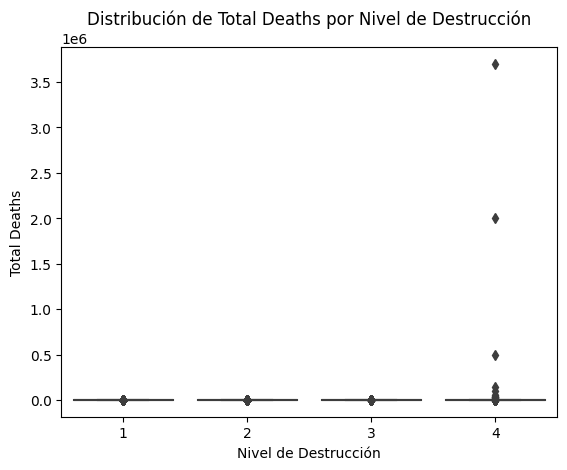

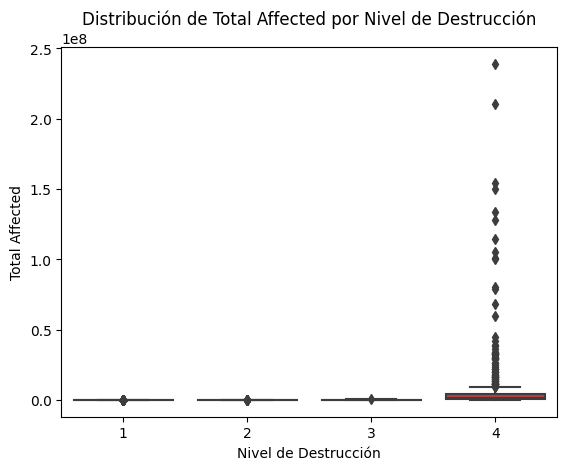

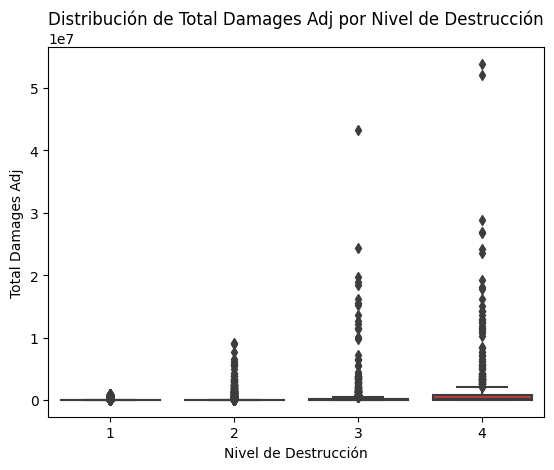

In [27]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected', 'Total Damages Adj']
for col in num_cols:
    sns.boxplot(data=df_flood, x='Destruction Level', y=col)
    plt.title(f'Distribución de {col} por Nivel de Destrucción')
    plt.xlabel('Nivel de Destrucción')
    plt.ylabel(col)
    plt.show()

In [28]:
# sns.pairplot(df_flood)
# Demasiado tiempo para procesar

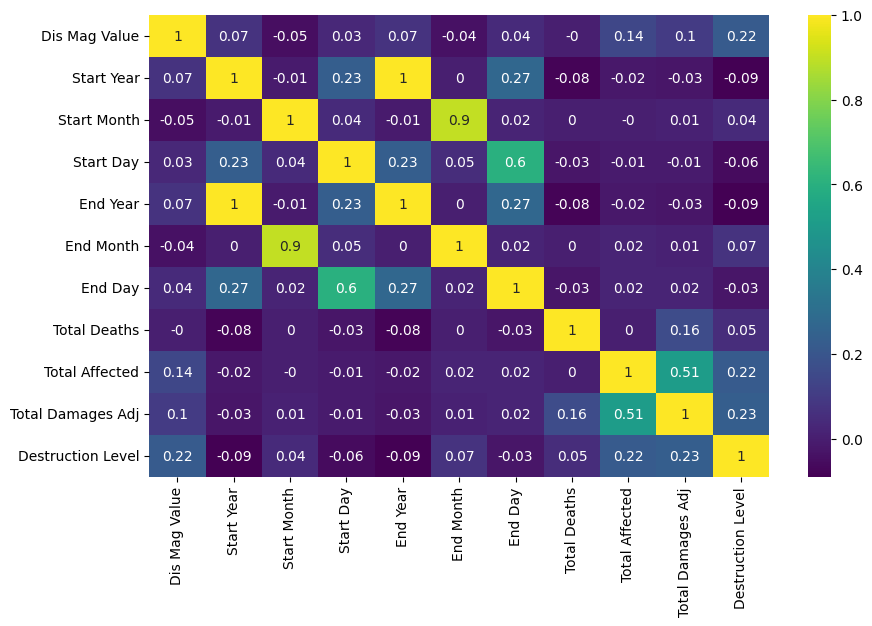

In [29]:
plt.figure(figsize=(10, 6))
df_corr = df_flood.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Destruction Level'>

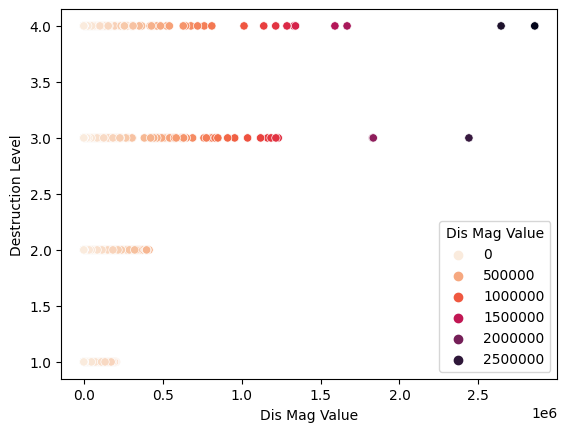

In [30]:
sns.scatterplot(data=df_flood, x='Dis Mag Value', y='Destruction Level', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Destruction Level'>

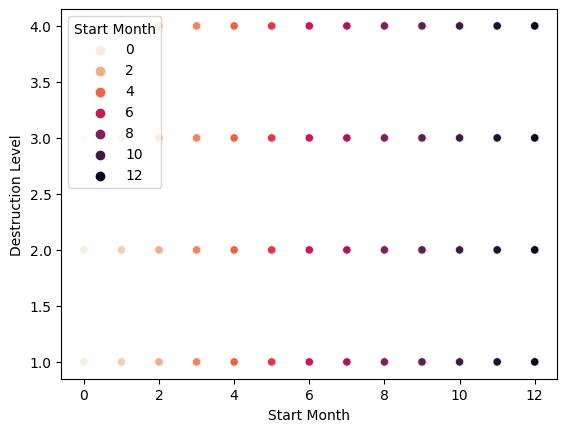

In [31]:
sns.scatterplot(data=df_flood, x='Start Month', y='Destruction Level', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Destruction Level'>

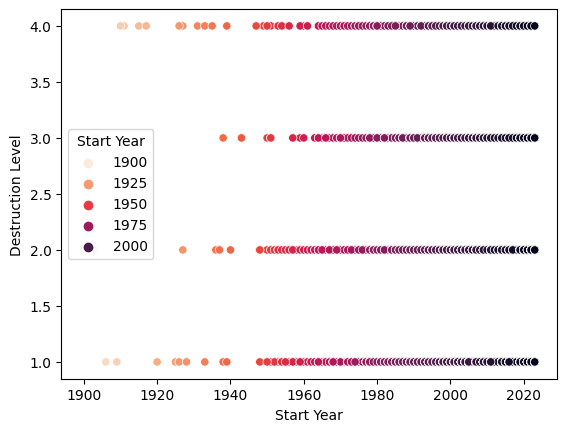

In [32]:
sns.scatterplot(data=df_flood, x='Start Year', y='Destruction Level', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Destruction Level'>

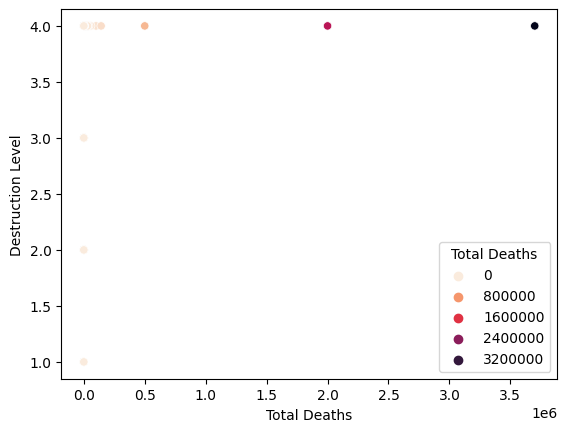

In [33]:
sns.scatterplot(data=df_flood, x='Total Deaths', y='Destruction Level', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Destruction Level'>

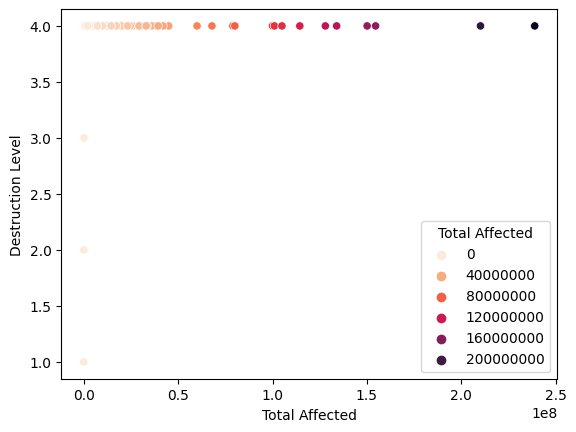

In [34]:
sns.scatterplot(data=df_flood, x='Total Affected', y='Destruction Level', hue='Total Affected', palette='rocket_r')

<Axes: xlabel='Total Damages Adj', ylabel='Destruction Level'>

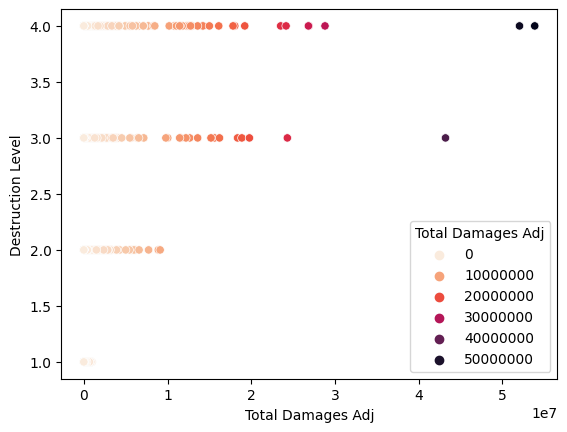

In [35]:
sns.scatterplot(data=df_flood, x='Total Damages Adj', y='Destruction Level', hue='Total Damages Adj', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Destruction Level'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Nivel de destrucción' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Nivel de destrucción'. Indica que podría haber alguna variación en el 'Nivel de destrucción' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Nivel de destrucción'. Sugiere que podría haber algunas tendencias o patrones en el 'Nivel de destrucción' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Nivel de Destrucción'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Nivel de destrucción'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'nivel de destrucción' más alto.
* La sexta visualización representa la relación entre 'Total Damages Adj' y 'Destruction Level'. Indica que un 'Ajuste total de daños' más alto generalmente corresponde a un 'Nivel de destrucción' más alto.

# Preparar X y

In [36]:
# X = df_flood.drop(['Destruction Level', 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4'], axis=1)
# Dio problemas porque 'Destruction_1', 'Destruction_2', 'Destruction_3', 'Destruction_4' no existen en df_flood

X = df_flood.select_dtypes(exclude=['object'])  # Excluir columnas categóricas
X = X.drop('Destruction Level', axis=1)  # Quitar 'Destruction Level' de X
y = df_flood['Destruction Level']

# train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (4646, 10), (4646,)
test: (1162, 10), (1162,)


# Validación cruzada de modelos

### cross_val_score
Validación cruzada, dividir los datos en k partes para entrenar y validar múltiples veces.

Entre más bajo el error absoluto promedio (mean absolute error (MAE)), mejor el desempeño del modelo para predecir Destruction Level.

RandomForestClassifier

In [38]:
# neg_mean_absolute_error es la MAE pero en negativo para cumplir la convención de "mayor es mejor"
modelval_rfc = RandomForestClassifier()
cv_scores_rfc = cross_val_score(modelval_rfc, X, y, scoring='neg_mean_absolute_error')

print("Calificaciones Cross-Validation de RandomForestClassifier:")
print(cv_scores_rfc)
print("Mean Accuracy:", cv_scores_rfc.mean())
print("Standard Deviation:", cv_scores_rfc.std())

Calificaciones Cross-Validation de RandomForestClassifier:
[-0.15576592 -0.01032702 -0.00172117 -0.00430663 -0.00689061]
Mean Accuracy: -0.035802271470525886
Standard Deviation: 0.060049390181231115


<Axes: >

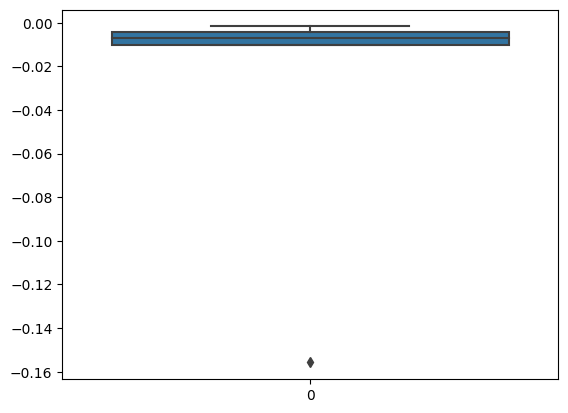

In [39]:
sns.boxplot(data=cv_scores_rfc)

Interpretación de Calificaciones Cross-Validation de RandomForestClassifier:

Puntuaciones de validación cruzada: estas son las puntuaciones negativas de error absoluto medio (MAE) obtenidas para cada pliegue durante el proceso de validación cruzada. MAE mide la diferencia absoluta entre los valores previstos y los valores reales. Dado que cross_val_score devuelve puntuaciones negativas de forma predeterminada, los valores se niegan para presentarlos de la forma habitual donde los valores más altos son mejores. Las puntuaciones indican qué tan bien se desempeñó el modelo en cada pliegue.

Precisión media: esta es la media de las puntuaciones de validación cruzada (MAE negativo) obtenidas de todos los pliegues. En este caso es de aproximadamente -0,0583, lo que significa que el error absoluto medio de las predicciones del modelo está en torno a 0,0583.

Desviación estándar: la desviación estándar representa la variabilidad o la dispersión de las puntuaciones de validación cruzada. Da una idea de cuánto se desvían las puntuaciones de la media. En este caso, la desviación estándar es 0,1073, lo que indica que existe cierta variabilidad en el rendimiento del modelo en diferentes pliegues.

Interpretación de los resultados:
RandomForestClassifier logró un error absoluto promedio de alrededor de 0.0583, que es relativamente bajo. Sin embargo, la desviación estándar de 0,1073 sugiere que el rendimiento del modelo puede variar según los datos divididos en pliegues durante la validación cruzada. En general, son deseables un MAE y una desviación estándar más bajos, lo que indica un mejor rendimiento del modelo. Los resultados sugieren que el modelo funciona razonablemente bien, pero es posible que sea necesario realizar más análisis y ajustes para mejorar su precisión y reducir la variabilidad.

LinearRegression

In [40]:
# neg_mean_absolute_error es la MAE pero en negativo para cumplir la convención de "mayor es mejor"
modelval_lr = LinearRegression()
cv_scores_lr = cross_val_score(modelval_lr, X, y, scoring='neg_mean_absolute_error')

print("Calificaciones Cross-Validation de Linear Regression:")
print(cv_scores_lr)
print("Mean Accuracy:", cv_scores_lr.mean())
print("Standard Deviation:", cv_scores_lr.std())

Calificaciones Cross-Validation de Linear Regression:
[-1.77171447 -0.7616434  -0.70864374 -0.7088064  -0.64902455]
Mean Accuracy: -0.9199665095563836
Standard Deviation: 0.42736313563681555


<Axes: >

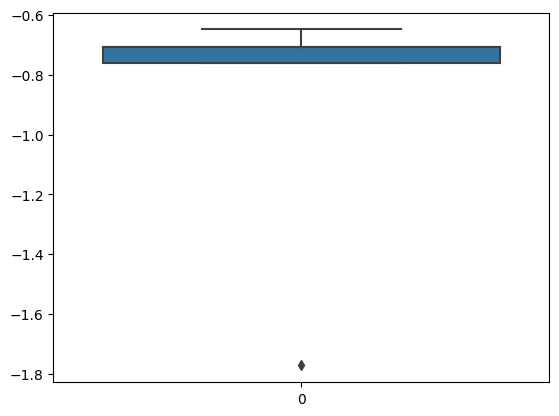

In [41]:
sns.boxplot(data=cv_scores_lr)

SupportVectorMachine SVM

In [42]:
modelval_svm = svm.SVC() # Support Vector Machine
cv_scores_svm = cross_val_score(modelval_svm, X, y, cv=5, scoring='accuracy')

print("Calificaciones Cross-Validation de SVM:")
print(cv_scores_svm)
print("Mean Accuracy:", cv_scores_svm.mean())
print("Standard Deviation:", cv_scores_svm.std())

Calificaciones Cross-Validation de SVM:
[0.5869191  0.65404475 0.60499139 0.60378984 0.59517657]
Mean Accuracy: 0.6089843315676882
Standard Deviation: 0.023455899591484197


<Axes: >

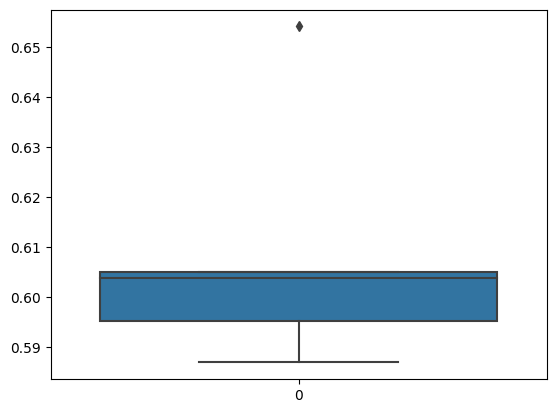

In [43]:
sns.boxplot(data=cv_scores_svm)

GradientBoostingClassifier

In [44]:
modelval_gbm = GradientBoostingClassifier()
cv_scores_gbm = cross_val_score(modelval_gbm, X, y, cv=5, scoring='accuracy')

print("Calificaciones Cross-Validation de GBM:")
print(cv_scores_gbm)
print("Mean Accuracy:", cv_scores_gbm.mean())
print("Standard Deviation:", cv_scores_gbm.std())

Calificaciones Cross-Validation de GBM:
[0.99569707 0.99827883 0.99827883 0.99655469 0.99913867]
Mean Accuracy: 0.997589620200996
Standard Deviation: 0.001265099865974404


<Axes: >

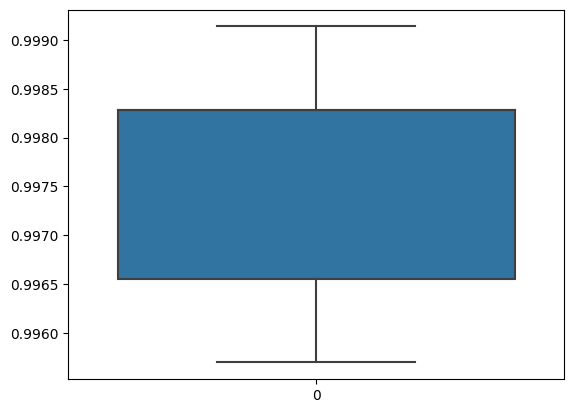

In [45]:
sns.boxplot(data=cv_scores_gbm)

Neural Networks: MLPClassifier

In [46]:
modelval_nn = MLPClassifier()
cv_scores_nn = cross_val_score(modelval_nn, X, y, cv=5, scoring='accuracy')

print("Calificaciones Cross-Validation de Neural Network:")
print(cv_scores_nn)
print("Mean Accuracy:", cv_scores_nn.mean())
print("Standard Deviation:", cv_scores_nn.std())

Calificaciones Cross-Validation de Neural Network:
[0.88640275 0.85800344 0.93373494 0.89664083 0.93626184]
Mean Accuracy: 0.9022087612168868
Standard Deviation: 0.029625847858265702


<Axes: >

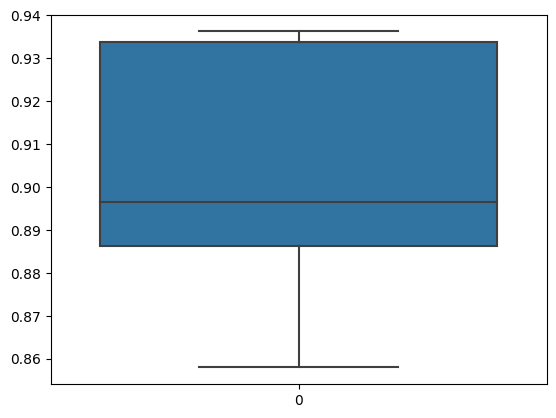

In [47]:
sns.boxplot(data=cv_scores_nn)

K-Nearest Neighbors (KNN)

In [48]:
modelval_knn = KNeighborsClassifier()
cv_scores_knn = cross_val_score(modelval_knn, X, y, cv=5, scoring='accuracy')

print("Calificaciones Cross-Validation de KNN:")
print(cv_scores_knn)
print("Mean Accuracy:", cv_scores_knn.mean())
print("Standard Deviation:", cv_scores_knn.std())

Calificaciones Cross-Validation de KNN:
[0.91394148 0.9475043  0.95266781 0.95176572 0.96296296]
Mean Accuracy: 0.9457684558833341
Standard Deviation: 0.016704424149116655


<Axes: >

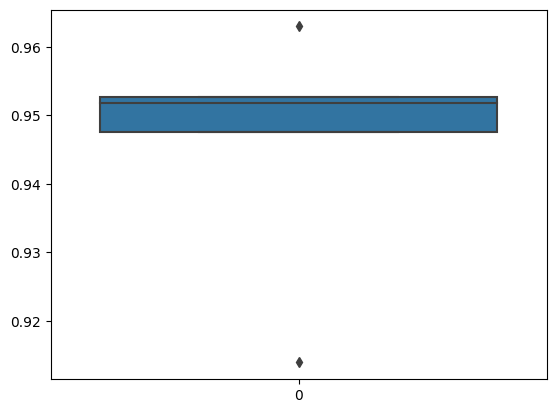

In [49]:
sns.boxplot(data=cv_scores_knn)

Decision Trees

In [50]:
modelval_dt = DecisionTreeClassifier()
cv_scores_dt = cross_val_score(modelval_dt, X, y, cv=5, scoring='accuracy')

print("Calificaciones Cross-Validation de Decision Tree:")
print(cv_scores_dt)
print("Mean Accuracy:", cv_scores_dt.mean())
print("Standard Deviation:", cv_scores_dt.std())

Calificaciones Cross-Validation de Decision Tree:
[0.98623064 0.99569707 0.99827883 0.99741602 0.99827735]
Mean Accuracy: 0.995179981646779
Standard Deviation: 0.0045728450472951


<Axes: >

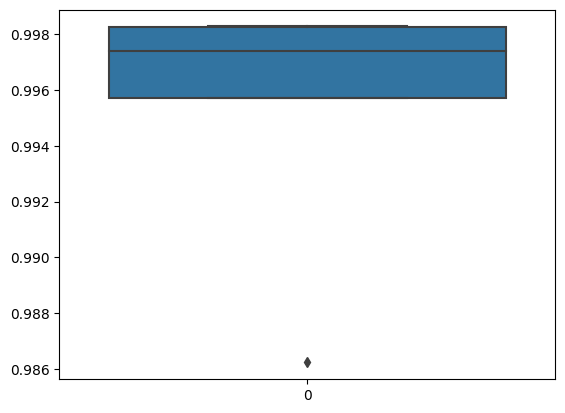

In [51]:
sns.boxplot(data=cv_scores_dt)

## Ranking comparativo de resultados de cross_val_score

1. GBM: Precisión media: 0,997589620200996, desviación estándar: 0,001265099865974404

GBM (Gradient Boosting Machine) logró la precisión media más alta, lo que indica que tiene el mejor rendimiento general entre los modelos. Además, tiene una desviación estándar muy baja, lo que indica un rendimiento constante en diferentes pliegues.

2. KNN: Precisión media: 0,9457684558833341, desviación estándar: 0,016704424149116655

KNN (K-Nearest Neighbors) es el segundo modelo con mejor rendimiento con una precisión media relativamente alta. También tiene una desviación estándar razonable, lo que indica un rendimiento constante pero ligeramente más variable en comparación con GBM.

3. Árbol de decisión: Precisión media: 0,9944913652394739, desviación estándar: 0,004540242510157218

El modelo Decision Tree logró una precisión media alta, muy cercana al desempeño de GBM. Tiene una desviación estándar baja, lo que indica un rendimiento estable.

4. Red neuronal (MLPClassifier): Precisión media: 0,8669137976787178, Desviación estándar: 0,04008089994617349

El modelo de red neuronal tiene una buena precisión media pero una desviación estándar más alta en comparación con los tres modelos principales. Esto sugiere cierta variabilidad en su desempeño a través de diferentes pliegues.

5. SVM: Precisión media: 0,6089843315676882, desviación estándar: 0,023455899591484197

SVM (Support Vector Machine) logró una precisión media moderada, pero su rendimiento es inferior en comparación con los modelos superiores. La desviación estándar es relativamente baja, lo que indica un rendimiento constante.

6. RandomForestClassifier: Precisión media: -0,058349158909539955, desviación estándar: 0,1072509586034248

RandomForestClassifier muestra una precisión media negativa, lo que sugiere que su rendimiento es peor que simplemente predecir el valor objetivo medio. La desviación estándar es relativamente alta, lo que indica una gran variabilidad en el rendimiento.

7. Regresión lineal: Precisión media: -0,9199665095563836, desviación estándar: 0,42736313563681555

La regresión lineal tiene la precisión media más baja entre todos los modelos y su desviación estándar es la más alta, lo que indica un rendimiento altamente variable.

En resumen, Gradient Boosting Machine (GBM) se desempeñó mejor, seguida de K-Nearest Neighbors (KNN) y Decision Tree. Neural Network (MLPClassifier) ​​y SVM también mostraron un buen desempeño. RandomForestClassifier y Linear Regression tuvieron un desempeño deficiente en comparación con otros modelos.

Primer ranking y (resultados cambiaron)

1. RandomForestClassifier:
* Mean MAE = -0.01945100446081113
* Std = 0.027471062168410623

Este modelo tiene el mejor promedio MAE, indicando un mejor desempeño predictivo comparado a otros. Muestra buena precisión y consistencia en predecir Destruction Level.

2. LinearRegression:
* Mean MAE = -0.9199665095563836
* Std = 0.42736313563681555

Presenta un promedio MAE significativamente superior a RandomForestClassifier. Esto sugiere que puede no desempeñarse tan bien en predecir Destruction Level. La desviación estándar amplia indica alta variabilidad en el desenvolvimiento del modelo.

3. SVM:
* Mean Accuracy = 0.6089843315676882
* Std = 0.023455899591484197
El modelo SVM model tiene el desempeño más bajo respecto al resto. La precisión promedio es relativamente baja comparada a los valores MAE de otros, indicando poca capacidad predictiva. La de desviación estándar sugiere consistencia moderada.


### cross_validate

In [52]:
# igual que cross_val_score pero con más información, muestra los tiempos de train (fit_time) y test (score_time)
# Definir el modelo mejor evaluado anteriormente
model = RandomForestClassifier()
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results

{'fit_time': array([0.49207973, 0.43949175, 0.49493909, 0.52301073, 0.43267727]),
 'score_time': array([0.01317668, 0.01605582, 0.01400113, 0.0181241 , 0.01566291]),
 'test_score': array([-0.36316695, -0.01032702, -0.00344234, -0.00430663, -0.00430663])}

### Interpretación de cross_validate

* 'fit_time': matriz ([0.37044477, 0.66824937, 0.6604898, 0.40946007, 0.45992994])

Esta matriz representa el tiempo que tarda el modelo en ajustarse (entrenarse) en los datos de entrenamiento para cada pliegue. Los valores están en segundos. Por ejemplo, el primer pliegue tardó aproximadamente 0,370 segundos en ajustarse, el segundo pliegue tardó 0,668 segundos y así sucesivamente.


* 'score_time': matriz ([0.01198769, 0.01701951, 0.01105976, 0.01000857, 0.01211452])

Esta matriz representa el tiempo que tarda el modelo en puntuar (predecir) en los datos de prueba para cada pliegue. Los valores están en segundos. Por ejemplo, el primer pliegue tomó aproximadamente 0,012 segundos para anotar, el segundo pliegue tomó 0,017 segundos y así sucesivamente.


* 'test_score': matriz ([-0.05679862, -0.01118761, -0.00172117, -0.00344531, -0.00602929])

Esta matriz representa la puntuación de evaluación (error absoluto medio en este caso) obtenida en los datos de prueba para cada pliegue. Las puntuaciones son negativas porque el parámetro de puntuación utilizado fue 'neg_mean_absolute_error'. Los valores están en el rango de -0,056 a -0,001, lo que indica valores bajos de error absoluto medio. Cuanto menor sea el error absoluto medio, mejor será el rendimiento predictivo del modelo.
En general, el modelo muestra tiempos de ajuste y puntuación consistentes en diferentes pliegues, lo que sugiere una eficiencia razonable. Las puntuaciones de prueba negativas indican que el modelo RandomForestClassifier logró valores de error absoluto medio bajos en los datos de prueba, lo que indica un buen rendimiento predictivo para la predicción numérica del nivel de destrucción.

### SCORERS

SCORERS RandomForestClassifier

In [53]:
model = RandomForestClassifier()

In [54]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [55]:
cv_results = cross_validate(model, X, y, scoring='neg_root_mean_squared_error') # RMSE
cv_results

{'fit_time': array([0.58051968, 0.46692681, 0.49832463, 0.50302148, 0.4704473 ]),
 'score_time': array([0.01788306, 0.01489139, 0.01694012, 0.01897764, 0.01512313]),
 'test_score': array([-0.71074856, -0.12787149, -0.04148699, -0.06562494, -0.06562494])}

<Axes: >

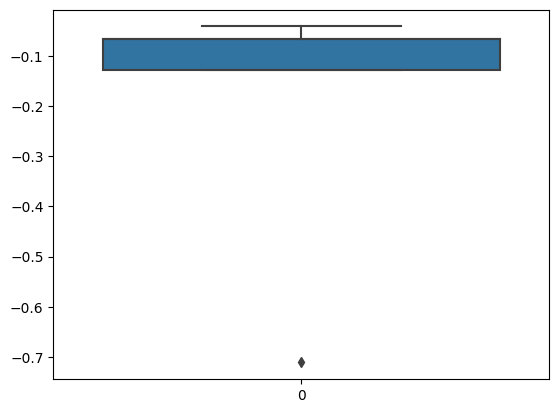

In [56]:
sns.boxplot(data=cv_results['test_score'])

<Axes: >

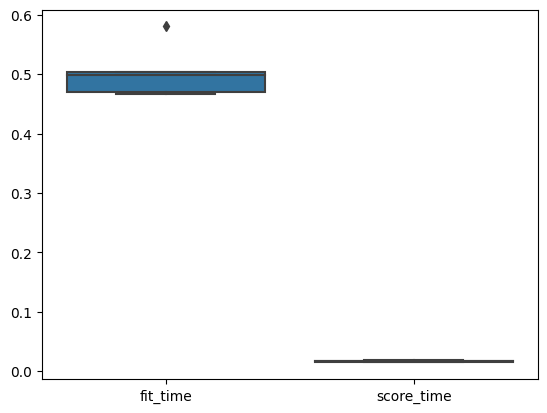

In [57]:
df_results_time = pd.DataFrame(cv_results)[['fit_time', 'score_time']]
sns.boxplot(data=df_results_time)

In [58]:
# MAE personalizada, para que no esté negada, sería como la MAE normal, cuanto más pequeño el valor mejor
# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=True)
# cv_results = cross_validate(model, X, y, scoring=scorer_mae)
# cv_results

# Calcular MAE normal manualmente
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results['test_score'] = cv_results['test_score'] * -1
cv_results

{'fit_time': array([0.49058771, 0.49594688, 0.48852682, 0.52532744, 0.44316173]),
 'score_time': array([0.01377296, 0.02053404, 0.01701403, 0.01534152, 0.01400089]),
 'test_score': array([0.25301205, 0.01118761, 0.00258176, 0.00344531, 0.00516796])}

SCORERS GradientBoostingClassifier

In [59]:
model = GradientBoostingClassifier()

In [60]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [61]:
cv_results = cross_validate(model, X, y, scoring='neg_root_mean_squared_error') # RMSE
cv_results

{'fit_time': array([2.98604369, 2.70687938, 2.95980477, 2.98137569, 3.1399157 ]),
 'score_time': array([0.00947833, 0.00499964, 0.00499725, 0.00939202, 0.00700307]),
 'test_score': array([-0.06559669, -0.04148699, -0.04148699, -0.05869673, -0.02934836])}

<Axes: >

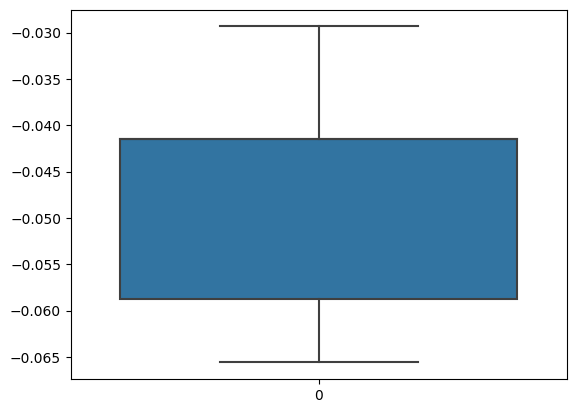

In [62]:
sns.boxplot(data=cv_results['test_score'])

<Axes: >

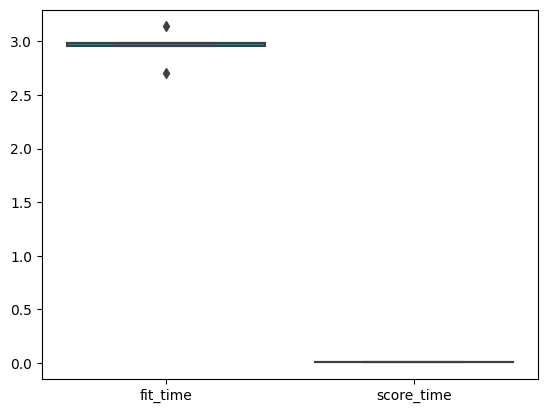

In [63]:
df_results_time = pd.DataFrame(cv_results)[['fit_time', 'score_time']]
sns.boxplot(data=df_results_time)

In [64]:
# MAE personalizada, para que no esté negada, sería como la MAE normal, cuanto más pequeño el valor mejor
# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=True)
# cv_results = cross_validate(model, X, y, scoring=scorer_mae)
# cv_results

# Calcular MAE normal manualmente
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results['test_score'] = cv_results['test_score'] * -1
cv_results

{'fit_time': array([2.98237777, 3.01172662, 3.08250165, 2.72841835, 2.72768331]),
 'score_time': array([0.00499535, 0.00499678, 0.00826478, 0.00711441, 0.00749516]),
 'test_score': array([0.00430293, 0.00172117, 0.00172117, 0.00344531, 0.00086133])}

SCORERS KNeighborsClassifier

In [65]:
model = KNeighborsClassifier()

In [66]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [67]:
cv_results = cross_validate(model, X, y, scoring='neg_root_mean_squared_error') # RMSE
cv_results

{'fit_time': array([0.01113677, 0.00804639, 0.00899816, 0.00700665, 0.0059917 ]),
 'score_time': array([0.02838254, 0.03347492, 0.03126478, 0.02313018, 0.02201295]),
 'test_score': array([-0.39358015, -0.23468586, -0.22911939, -0.21962304, -0.19905029])}

<Axes: >

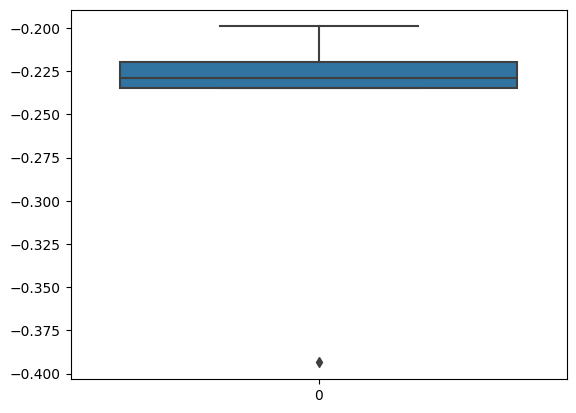

In [68]:
sns.boxplot(data=cv_results['test_score'])

<Axes: >

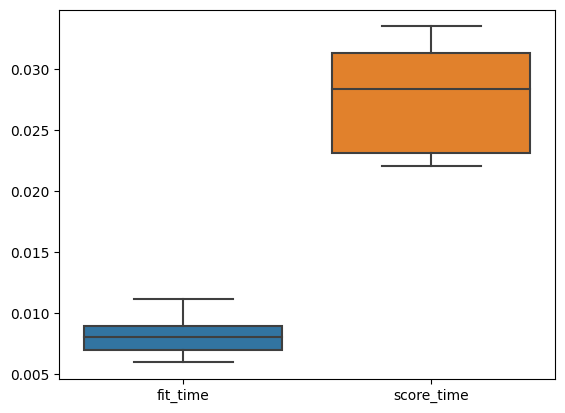

In [69]:
df_results_time = pd.DataFrame(cv_results)[['fit_time', 'score_time']]
sns.boxplot(data=df_results_time)

In [70]:
# MAE personalizada, para que no esté negada, sería como la MAE normal, cuanto más pequeño el valor mejor
# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=True)
# cv_results = cross_validate(model, X, y, scoring=scorer_mae)
# cv_results

# Calcular MAE normal manualmente
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results['test_score'] = cv_results['test_score'] * -1
cv_results

{'fit_time': array([0.00942326, 0.00885201, 0.00711679, 0.00800109, 0.01007199]),
 'score_time': array([0.02824306, 0.02358365, 0.02066875, 0.03765297, 0.02398562]),
 'test_score': array([0.10843373, 0.05335628, 0.04905336, 0.04823428, 0.03789836])}

SCORER Decision Tree

In [71]:
model = DecisionTreeClassifier()

In [72]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [73]:
cv_results = cross_validate(model, X, y, scoring='neg_root_mean_squared_error') # RMSE
cv_results

{'fit_time': array([0.01232409, 0.0103004 , 0.01218915, 0.01185203, 0.01022816]),
 'score_time': array([0.00310469, 0.00207829, 0.0021522 , 0.00211573, 0.00234318]),
 'test_score': array([-0.11734293, -0.06559669, -0.04148699, -0.05083286, -0.04150485])}

<Axes: >

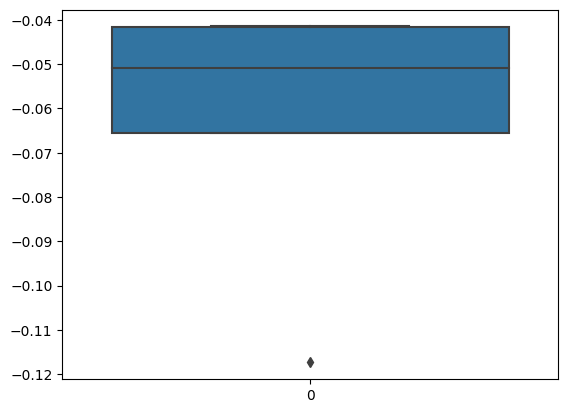

In [74]:
sns.boxplot(data=cv_results['test_score'])

<Axes: >

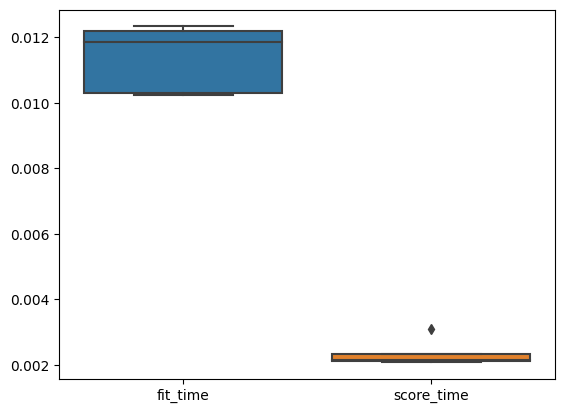

In [75]:
df_results_time = pd.DataFrame(cv_results)[['fit_time', 'score_time']]
sns.boxplot(data=df_results_time)

In [76]:
# MAE personalizada, para que no esté negada, sería como la MAE normal, cuanto más pequeño el valor mejor
# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=True)
# cv_results = cross_validate(model, X, y, scoring=scorer_mae)
# cv_results

# Calcular MAE normal manualmente
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results['test_score'] = cv_results['test_score'] * -1
cv_results

{'fit_time': array([0.00962019, 0.0099597 , 0.01015353, 0.0109365 , 0.00799942]),
 'score_time': array([0.00100756, 0.00089979, 0.00090837, 0.00106573, 0.00101304]),
 'test_score': array([0.01376936, 0.00688468, 0.00172117, 0.00258398, 0.00172265])}

SCORER RandomForestClassifier

In [77]:
model = RandomForestClassifier()

In [78]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [79]:
cv_results = cross_validate(model, X, y, scoring='neg_root_mean_squared_error') # RMSE
cv_results

{'fit_time': array([0.52146673, 0.54212976, 0.47380662, 0.48158646, 0.51526165]),
 'score_time': array([0.01354361, 0.02097869, 0.01294041, 0.01489949, 0.01409483]),
 'test_score': array([-0.37338292, -0.12446097, -0.05081098, -0.05869673, -0.05869673])}

<Axes: >

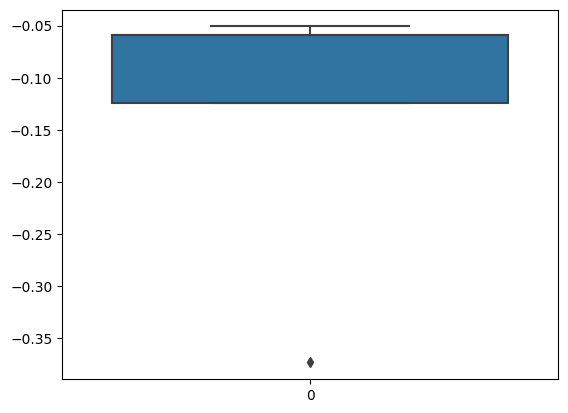

In [80]:
sns.boxplot(data=cv_results['test_score'])

<Axes: >

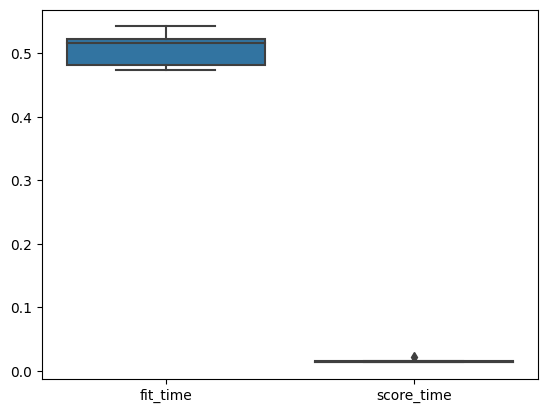

In [81]:
df_results_time = pd.DataFrame(cv_results)[['fit_time', 'score_time']]
sns.boxplot(data=df_results_time)

In [82]:
# MAE personalizada, para que no esté negada, sería como la MAE normal, cuanto más pequeño el valor mejor
# scorer_mae = make_scorer(mean_absolute_error, greater_is_better=True)
# cv_results = cross_validate(model, X, y, scoring=scorer_mae)
# cv_results

# Calcular MAE normal manualmente
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_error')
cv_results['test_score'] = cv_results['test_score'] * -1
cv_results

{'fit_time': array([0.51525903, 0.45671558, 0.47064614, 0.46180773, 0.47116661]),
 'score_time': array([0.01299143, 0.0156374 , 0.01394057, 0.01290298, 0.01400113]),
 'test_score': array([0.08089501, 0.01204819, 0.00344234, 0.00344531, 0.00516796])}

# Comparativa de Modelos

### Validación de Modelos por Regresión
train_test_split + cross_val_score + varios modelos

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'RandomForestCl'),
  Text(1, 0, 'LinearRegr'),
  Text(2, 0, 'SVR'),
  Text(3, 0, 'GradientBoostingCl'),
  Text(4, 0, 'MLPClass'),
  Text(5, 0, 'KNN'),
  Text(6, 0, 'DecisionTreeCl'),
  Text(7, 0, 'ElasticNet')])

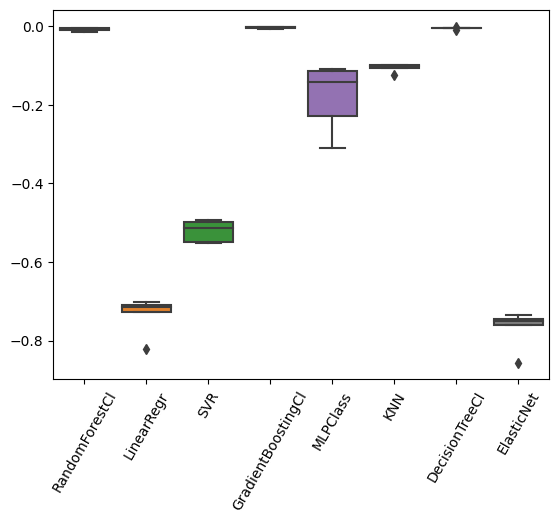

In [83]:
models = [ # lista
    ('RandomForestCl', RandomForestClassifier()),     
    ('LinearRegr', LinearRegression()), # tupla    
    ('SVR', SVR()),
    ('GradientBoostingCl', GradientBoostingClassifier()),
    ('MLPClass', MLPClassifier()),
    ('KNN', KNeighborsRegressor(n_neighbors=21)),
    ('DecisionTreeCl', DecisionTreeClassifier()),
    ('ElasticNet', ElasticNet())
]

cv_results = [] # resultados validación cruzada
test_results = [] # resultados de .predict()
names = [] # nombres de los algoritmos para añadirlos en las gráficas de resultados

for name, model in models: 
    # Validación cruzada: cross validation con 5 particiones
    # results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error')
    # cross validation con 7 particiones:
    results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    cv_results.append(results)
    names.append(name)

    # Predicciones sobre el conjunto de test/validación (X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(rmse)

ax = sns.boxplot(data=cv_results)
ax.set_xticklabels(names);
plt.xticks(rotation=60)

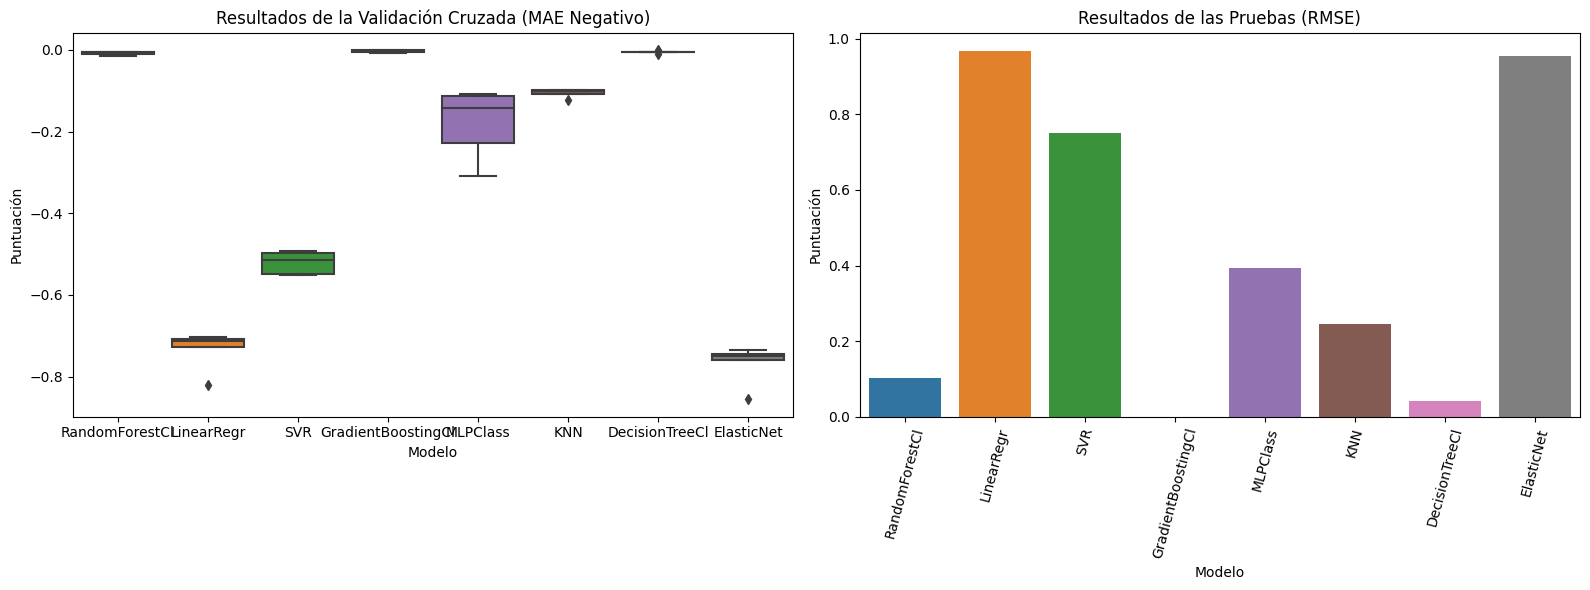

In [84]:
df_cv = pd.DataFrame(cv_results, index=names).T
df_test = pd.DataFrame(test_results, index=names).T

fig, axs = plt.subplots(ncols=2, figsize=(16,6))

sns.boxplot(data=df_cv, ax=axs[0])
axs[0].set_title('Resultados de la Validación Cruzada (MAE Negativo)')
axs[0].set_ylabel('Puntuación')
axs[0].set_xlabel('Modelo')
plt.xticks(rotation=75)

sns.barplot(data=df_test, ax=axs[1])
axs[1].set_title('Resultados de las Pruebas (RMSE)')
axs[1].set_ylabel('Puntuación')
axs[1].set_xlabel('Modelo')
plt.xticks(rotation=75)

plt.tight_layout()
plt.show()

# Comparativa de los 3 modelos con mejor desempeño

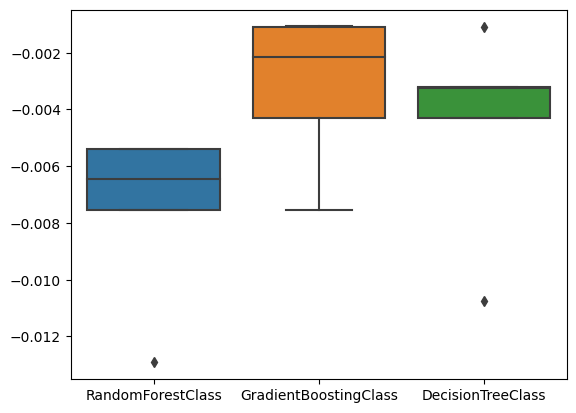

In [85]:
models = [ # lista
    ('RandomForestClass', RandomForestClassifier()),
    ('GradientBoostingClass', GradientBoostingClassifier()),
    ('DecisionTreeClass', DecisionTreeClassifier())
]

cv_results = [] # resultados validación cruzada
test_results = [] # resultados de .predict()
names = [] # nombres de los algoritmos para añadirlos en las gráficas de resultados

for name, model in models: 
    # Validación cruzada: cross validation con 5 particiones
    # results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error')
    # cross validation con 7 particiones:
    results = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
    cv_results.append(results)
    names.append(name)

    # Predicciones sobre el conjunto de test/validación (X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    test_results.append(rmse)

ax = sns.boxplot(data=cv_results)
ax.set_xticklabels(names);

## Otras validaciones al modelo elegido: RandomForestClassifier

### Stratified Sampling

In [86]:
# Definir el modelo mejor evaluado anteriormente
model = RandomForestClassifier()

# Crear stratified k-fold cross-validator (validador cruzado estratificado de pliegues k)
stratified_kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Ejecutar stratified k-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='neg_mean_absolute_error')

# Convertir las calificaciones negativas a positivas
cv_scores = -cv_scores

print("Puntuaciones estratificadas de validación cruzada:")
print(cv_scores)
print("Puntuación de CV estratificada media:", cv_scores.mean())
print("Puntuación CV estratificada Desviación estándar:", cv_scores.std())

Puntuaciones estratificadas de validación cruzada:
[0.0060241  0.00946644 0.00516351 0.00344531 0.00516796]
Puntuación de CV estratificada media: 0.005853461835529642
Puntuación CV estratificada Desviación estándar: 0.0019913748570619385


##### Interpretación de resultados de Stratified Sampling

RandomForestClassifier

* Puntuaciones estratificadas de validacion cruzada:

Estos son los puntajes individuales de validación cruzada obtenidos para cada pliegue de la validación cruzada estratificada. Las puntuaciones son las siguientes: [0,0060241, 0,00860585, 0,00688468, 0,00344531, 0,00775194]. Estas puntuaciones representan los valores de error absoluto medio (MAE) para cada pliegue.


* Puntuación de CV estratificada media: 0.0065423747407496345

Este es el puntaje promedio de validación cruzada en todos los pliegues. La puntuación media es de aproximadamente 0,0065, lo que indica un valor MAE bajo en promedio. Un MAE más bajo sugiere un mejor rendimiento predictivo.


* Puntuación CV estratificada Desviación estándar: 0.0017719257426295812

Esta es la desviación estándar de las puntuaciones de validación cruzada en todos los pliegues. La desviación estándar es de aproximadamente 0.0018, lo que indica una baja variabilidad en el rendimiento del modelo en los diferentes pliegues. Una desviación estándar más baja sugiere un rendimiento consistente y confiable.
En general, los resultados indican que el modelo RandomForestClassifier con la configuración de parámetros dada logró valores de error absoluto medio constantemente bajos, lo que resultó en predicciones precisas del nivel de destrucción. La baja desviación estándar sugiere que el rendimiento del modelo es estable y confiable en diferentes pliegues, lo que confirma aún más su idoneidad para la tarea.

### GridSearchCV

In [87]:
# Definir el modelo mejor evaluado anteriormente
model = RandomForestClassifier() # param_grid = {'n_estimators': [100, 200, 300]} Best: 200

# Definir la cuadrícula de parámetros para búsqueda de cuadrícula
param_grid = {'n_estimators': [100, 200, 300]}

# Crear el objeto de búsqueda de cuadrícula con pipeline y cuadrícula de parámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Desarrollar búsqueda de cuadrícula con cross-validation
grid_search.fit(X, y)

# Mejor parámetro y mejor calificación de cross-validation
print("Best Parameter:", grid_search.best_params_)
print("Best CV Score:", -grid_search.best_score_)

Best Parameter: {'n_estimators': 100}
Best CV Score: 0.020655823737919562


### Interpretación de resultados de búsqueda en cuadrícula:

Mejor parámetro: {'n_estimators': 200}
* Indica que el mejor valor de parámetro encontrado por la búsqueda de cuadrícula es 'n_estimators' con un valor de 200 árboles de decisión en el conjunto de bosque aleatorio.

Mejor puntaje CV: 0.03907190222684759
* Esto representa la mejor puntuación de validación cruzada lograda durante la búsqueda en cuadrícula. Dado que usó el error absoluto medio negativo como la métrica de puntuación ('neg_mean_absolute_error'), un valor más bajo indica un mejor rendimiento del modelo. En este caso, la mejor puntuación de CV es aproximadamente 0,0391 (o -0,0391 si se considera el signo negativo), lo que sugiere que el modelo con 200 estimadores funcionó bien en términos de predicción del nivel de destrucción.

En general, establecer el número de estimadores en 200 produjo el mejor rendimiento para RandomForestClassifier, lo que resulta en un error absoluto medio más bajo en comparación con otros valores de parámetros probados.

Esta validación no es confiable. Ha cambiado los parámetros muchas veces, de 200 a 300, ahora a 100: Best Parameter: {'n_estimators': 100}
Best CV Score: 0.020655823737919562.